## **Dog breed identification**

**Instructions:**
This notebook includes:
* Check / adjust data quality ✅
* Extract features from images ✅
* Reduce dimensionality ✅
* Classify dogs per breeds ✅




### Set up your environment

- First we load the dataset from kaggle

In [1]:
! pip install -q kaggle

In [2]:
# Here you need to upload your kaggle.json for the API key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sahishnutaa","key":"60fd29e0881dd544fdaaabafa464f0b4"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c dog-breed-identification
! unzip dog-breed-identification.zip -d dog-breed-identification

Streaming output truncated to the last 5000 lines.
  inflating: dog-breed-identification/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog-breed-identification/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog-breed-identification/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog-breed-identification/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog-breed-identification/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog-breed-identification/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog-breed-identification/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog-breed-identification/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog-breed-identification/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog-breed-identification/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog-breed-identification/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog-breed-identificatio

- We install all the needed libraries

In [4]:
import cv2
import os
import cv2
import tqdm
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
warnings.filterwarnings("ignore")                   # Suppressing Jupyter Notebook Warnings
from IPython.display import display, Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

### Exploratory Data Analysis for data quality review

- Adding all the train images to the context

In [5]:
train_img = [cv2.imread(file) for file in glob.glob("dog-breed-identification/train/*.jpg")]

- We display the images from the dataset

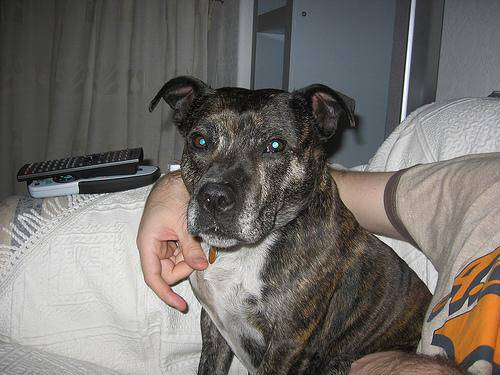

(375, 500, 3)

In [6]:
rand = np.random.randint(0, 5000)
cv2_imshow(train_img[rand])
train_img[rand].shape

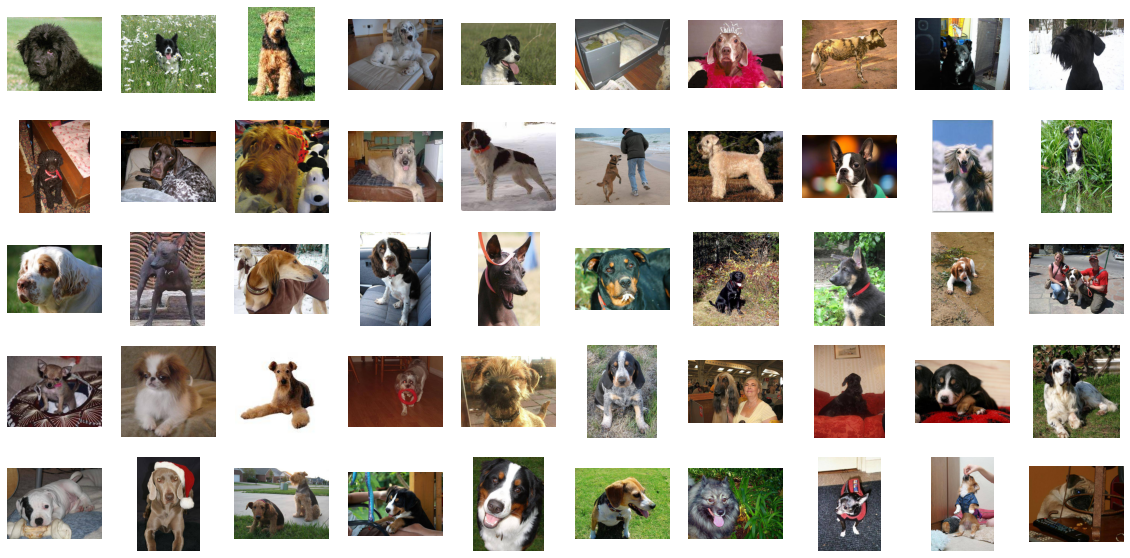

In [7]:
fig = plt.figure(figsize=(20, 10))
columns = 10
rows = 5
for i, img in zip(range(1, columns*rows +1), train_img):
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

- We explore the unique values of the labels of the images

In [8]:
labels = pd.read_csv('dog-breed-identification/labels.csv')
labels.describe(include='all')

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [9]:
unique_breeds = np.unique(labels['breed'])

print("Total number of unique breeds : ", len(unique_breeds))

Total number of unique breeds :  120


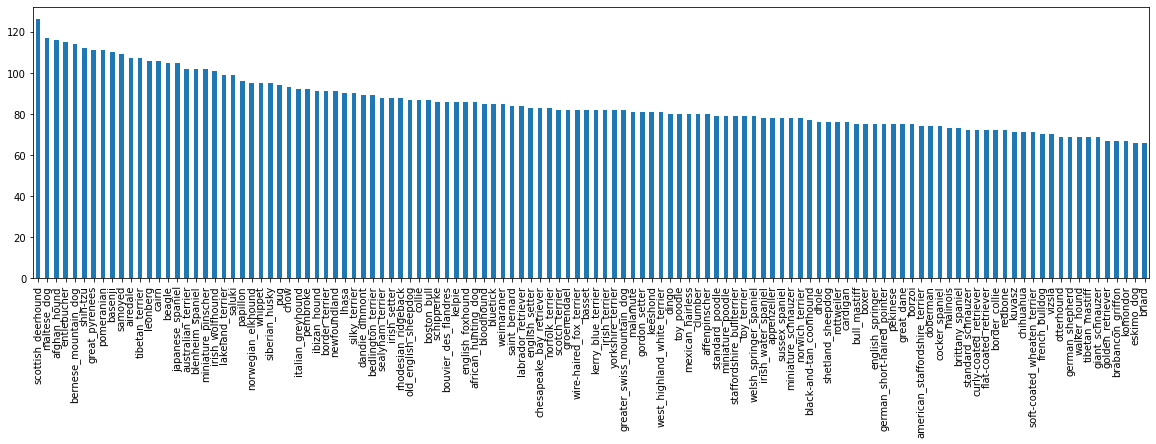

In [10]:
labels['breed'].value_counts().plot.bar(figsize=(20, 5))

- We analyze pictures dimensions and ratio 

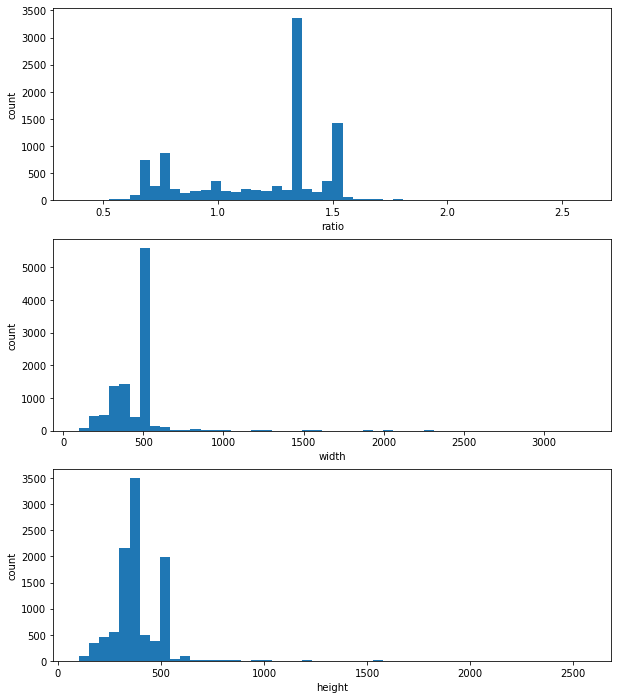

In [11]:
ratios = []
widths = []
heights = []

for img in train_img:
  ratios.append(img.shape[1] / img.shape[0])  
  heights.append(img.shape[0])
  widths.append(img.shape[1])

fig, ax = plt.subplots(3, figsize=(10, 12))

ax[0].hist(ratios, bins=50)
ax[0].set_xlabel('ratio')
ax[0].set_ylabel('count')

ax[1].hist(widths, bins=50)
ax[1].set_xlabel('width')
ax[1].set_ylabel('count')

ax[2].hist(heights, bins=50)
ax[2].set_xlabel('height')
ax[2].set_ylabel('count')

fig.show()

- We select the most common width and height and see if it matches with the most repeated ratio.

In [12]:
rep_w = np.bincount(widths).argmax()
rep_h = np.bincount(heights).argmax()

rep_ratio = np.argmax(np.bincount(ratios))
f'The most common height is {rep_h} and width is {rep_w} and here is the calculated ratio (w:h) {(rep_w/rep_h):.3f}'

'The most common height is 375 and width is 500 and here is the calculated ratio (w:h) 1.333'

- We resize the images based on the most repeated width and height, and turn images to black and white.

In [13]:
resize_params = (rep_w, rep_h)

train_resize = []

for img in train_img:
  img_resized = cv2.resize(img, resize_params, interpolation=cv2.INTER_LINEAR)
  img_grey = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
  train_resize.append(img_grey)

del train_img # to save memory

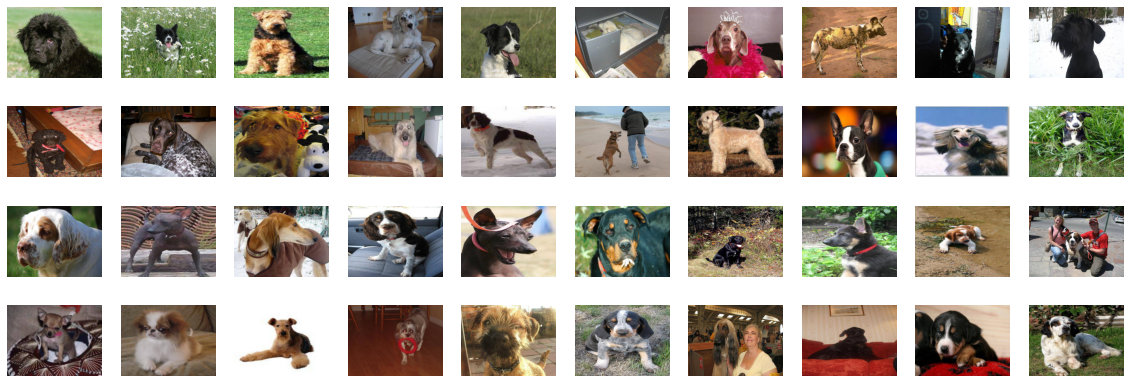

In [14]:
fig = plt.figure(figsize=(20, 7))
columns = 10
rows = 4
for i, img in zip(range(1, columns*rows +1), train_resize):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

### Feature extraction
- We separate the dataset in train and test sets

In [15]:
X = train_resize
y = LabelEncoder().fit_transform(labels['breed'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

print(f"Number of training images : {len(X_train)}")
print(f"Number of testing images : {len(X_test)}")

Number of training images : 6644
Number of testing images : 3578


- Testing of ORB to perform the feature extraction

In [16]:
orb = cv2.ORB_create(nfeatures=200)

image_sample = X_train[343]
leve1_image = X_train[121]

keypoints, descriptor = orb.detectAndCompute(image_sample, None)
keypoints_g, descriptor_g = orb.detectAndCompute(leve1_image, None)

keypoints_without_size = np.copy(image_sample)
keypoints_with_size = np.copy(image_sample)

- Displaying the results

Number of Keypoints Detected In The Training Image:  200
Number of Keypoints Detected In The Query Image:  200


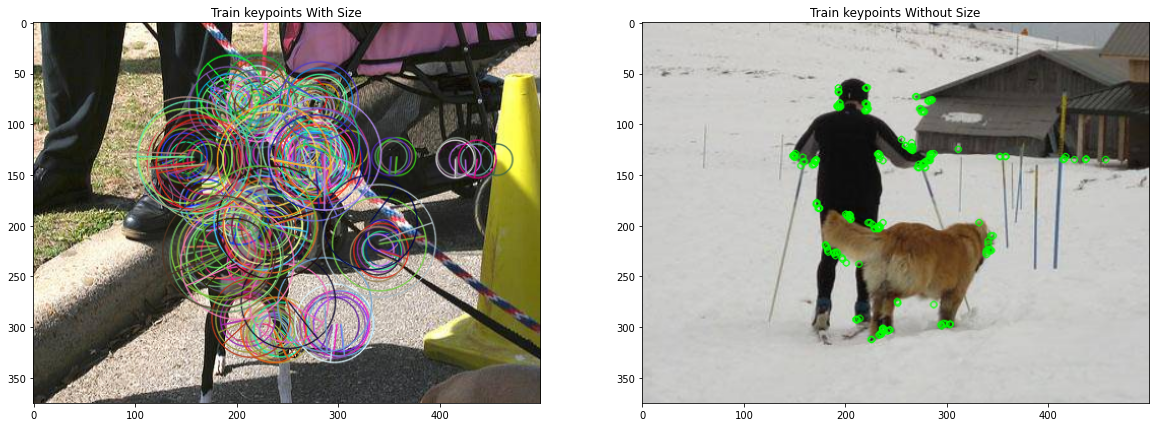

In [17]:
cv2.drawKeypoints(image_sample, keypoints, keypoints_without_size, color = (0, 255, 0))
cv2.drawKeypoints(leve1_image, keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size)

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size)

print("Number of Keypoints Detected In The Training Image: ", len(keypoints))
print("Number of Keypoints Detected In The Query Image: ", len(keypoints_g))

- Apply to the complete training set

In [18]:
orb = cv2.ORB_create(nfeatures=250)

keypts_ls = []
descript_ls = []

for img in X_train:
  keypts, descript = orb.detectAndCompute(img, None)
  keypts_ls.append(keypts)
  descript_ls.append(descript.flatten())

keypts_ls_test = []
descript_ls_test = []

for img in X_test:
  keypts_test, descript_test = orb.detectAndCompute(img, None)
  keypts_ls_test.append(keypts_test)
  descript_ls_test.append(descript_test.flatten())

- Transforming result of ORB into a DataFrame

In [19]:
keys_pd = pd.DataFrame(descript_ls)
keys_pd_test = pd.DataFrame(descript_ls_test)

keys_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999
0,98,-80,-32,-32,44,13,-39,17,11,-23,...,147.0,229.0,133.0,50.0,218.0,131.0,16.0,84.0,165.0,78.0
1,120,-57,-6,-28,-30,82,125,-11,33,46,...,246.0,144.0,83.0,89.0,80.0,127.0,215.0,12.0,94.0,215.0
2,-40,112,-104,-70,43,121,17,-116,-94,-42,...,123.0,23.0,13.0,140.0,21.0,118.0,216.0,218.0,82.0,184.0
3,-95,-35,33,-51,116,-51,79,-4,5,104,...,176.0,226.0,233.0,215.0,30.0,203.0,134.0,68.0,133.0,123.0
4,30,16,118,-35,63,-45,-72,75,-97,126,...,191.0,160.0,249.0,213.0,15.0,63.0,163.0,119.0,135.0,114.0


In [20]:
keys_pd_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999
0,-4,109,99,108,95,67,75,72,5,-92,...,205.0,45.0,226.0,237.0,33.0,184.0,44.0,179.0,2.0,17.0
1,-125,10,111,-3,126,-125,-23,112,52,21,...,37.0,79.0,244.0,175.0,162.0,128.0,109.0,160.0,97.0,249.0
2,41,-112,-21,-19,-12,-113,-23,19,118,65,...,210.0,183.0,127.0,156.0,21.0,126.0,210.0,136.0,194.0,170.0
3,67,-116,-113,-3,52,-84,105,22,-65,11,...,93.0,14.0,121.0,8.0,133.0,56.0,101.0,250.0,214.0,40.0
4,-4,-17,-81,55,-60,14,-17,-73,114,-2,...,26.0,243.0,127.0,9.0,142.0,111.0,147.0,92.0,189.0,130.0


### Dimensionality reduction
- Let's fill our dataset and normalize it

In [21]:
keys_pd = keys_pd.fillna(0)
keys_pd_test = keys_pd_test.fillna(0)

keys_norm = (keys_pd - keys_pd.mean()) / keys_pd.std()
keys_norm_test = (keys_pd_test - keys_pd_test.mean()) / keys_pd_test.std()

- We perform PCA on our keys

In [22]:
pca = PCA(n_components=80)
pca = pca.fit(keys_norm)
keys_pca = pca.transform(keys_norm)
keys_pca

array([[  3.92229961,  -4.8270552 ,   5.14752744, ...,   0.47133572,
          1.86012231,  -2.31479451],
       [  2.75130759,  -3.32682854,  -3.85202047, ...,  -0.24759203,
          0.75496477,   1.17724933],
       [ 17.33810437,   1.49028332,  -5.73710844, ...,   2.97432768,
          2.24551138,  -1.2460929 ],
       ...,
       [-13.08123873,  -2.63839965,   4.28986527, ...,   4.9455888 ,
         -1.15081662,  -3.99653843],
       [ -3.82631364,  -2.95666329,  -2.50464868, ...,  -1.12140133,
         -1.68372257,   0.86412248],
       [ -3.6668127 ,   1.58874065,  -6.47085991, ...,   1.08496047,
         -0.18239966,   3.55108388]])

In [23]:
keys_pca_test = pca.transform(keys_norm_test)
keys_pca_test

array([[ -5.45144682, -10.8029907 ,  -5.27699347, ...,   2.36227448,
          3.36081701,  -0.75121612],
       [-11.10575321,  -1.33634608,  -6.28772597, ...,   1.66203262,
         -0.84839804,  -2.58305685],
       [ -2.27108368,   6.36926511,   5.60294341, ...,  -0.39729919,
         -1.83130128,   0.24513445],
       ...,
       [  5.03823528,   2.28551339,   4.7222204 , ...,  -0.22313677,
          1.32424078,   1.0173069 ],
       [  3.64738584,   2.93379984,   0.71519193, ...,  -0.54378853,
         -0.19867111,   1.48523697],
       [ -2.30402889,  -5.65875142,  -0.44896072, ...,   4.00308344,
         -0.20972079,  -2.24569668]])

- Definition of SVM to perform the analysis </br>

In [24]:
svm = SVC(kernel='poly', degree=3, C=1.75)
svm.fit(keys_pca, y_train)

SVC(C=1.75, kernel='poly')

In [25]:
y_pred = svm.predict(keys_pca)

print(classification_report(y_pred=y_pred, y_true=y_train))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        52
           1       0.65      1.00      0.79        76
           2       1.00      1.00      1.00        53
           3       1.00      1.00      1.00        63
           4       0.98      0.90      0.94        51
           5       1.00      0.86      0.92        49
           6       1.00      1.00      1.00        65
           7       0.63      1.00      0.78        76
           8       1.00      0.91      0.95        53
           9       0.92      1.00      0.96        70
          10       1.00      0.90      0.95        48
          11       1.00      1.00      1.00        71
          12       1.00      0.96      0.98        53
          13       1.00      0.98      0.99        54
          14       1.00      0.88      0.93        49
          15       1.00      0.98      0.99        55
          16       1.00      0.89      0.94        44
          17       1.00    

In [26]:
y_pred_ = svm.predict(keys_pca_test)

print(classification_report(y_pred=y_pred_, y_true=y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.01      0.10      0.02        40
           2       0.00      0.00      0.00        33
           3       0.00      0.00      0.00        44
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        29
           6       0.00      0.00      0.00        37
           7       0.01      0.12      0.02        34
           8       0.00      0.00      0.00        29
           9       0.04      0.03      0.03        35
          10       0.00      0.00      0.00        41
          11       0.00      0.00      0.00        43
          12       0.00      0.00      0.00        24
          13       0.00      0.00      0.00        48
          14       0.00      0.00      0.00        36
          15       0.00      0.00      0.00        30
          16       0.00      0.00      0.00        28
          17       0.00    

### Transfer learning from VGG16 as model

- Loading VGG16

In [ ]:
files = glob.glob("dog-breed-identification/train/*.jpg")
images = [cv2.imread(file) for file in files[:5000]]

le = LabelEncoder()

labels = pd.read_csv('dog-breed-identification/labels.csv').head(5000)
labels_breed = labels['breed']

labels_encoded = le.fit_transform(labels_breed)

del le
del labels

resized = []

for image in images:
  image_resized = cv2.resize(image, (500, 375), interpolation=cv2.INTER_LINEAR)
  resized.append(image_resized)

del images # save memory

resized_arr = np.array(resized)
del resized

X_train, X_test, y_train, y_test = train_test_split(resized_arr, labels_encoded, test_size=0.2, random_state=1)

del resized_arr

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


In [ ]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(375, 500, 3))
base_model.summary()

- We freeze all layer before adding new

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

- We add 3 new layers to our model

In [ ]:
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model

labels_count = 120

output = base_model.output
output = Flatten()(output)
output = Dropout(0.6)(output)
output = Dense(labels_count, activation='softmax')(output)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
l = []
n = []

for layer in model.layers:
  l.append(layer.trainable)
  n.append(layer.name)

print(l)
print(n)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True]
['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'flatten', 'dropout', 'dense']


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fitted = model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/3
94/94 [==============================] - 99s 872ms/step - loss: 150.6538 - accuracy: 0.0063 - val_loss: 175.7040 - val_accuracy: 0.0090
Epoch 2/3
94/94 [==============================] - 81s 868ms/step - loss: 5.5744 - accuracy: 0.9047 - val_loss: 185.5278 - val_accuracy: 0.0100
Epoch 3/3
94/94 [==============================] - 82s 870ms/step - loss: 3.3872 - accuracy: 0.9253 - val_loss: 208.3017 - val_accuracy: 0.0100


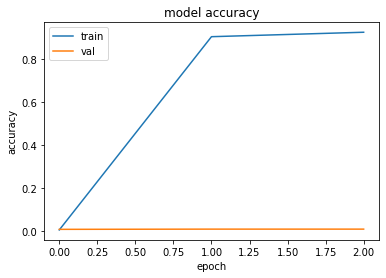

In [ ]:
plt.plot(fitted.history['accuracy'])
plt.plot(fitted.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

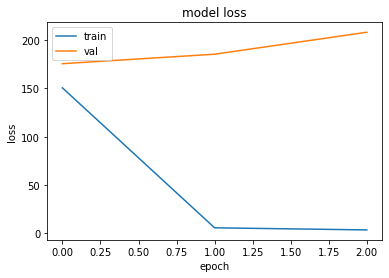

In [ ]:
plt.plot(fitted.history['loss'])
plt.plot(fitted.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()